# Comparing CATE-BLP to Plugin Interactive Linear Model 

In [1]:
# Setup
remotes::install_github("christophergandrud/blpopt")
remotes::install_github("christophergandrud/drlearner")

xfun::pkg_attach2("blpopt", "drlearner", "grf", "tidyr", "dplyr", "ggplot2")

theme_set(theme_minimal())

Skipping install of 'blpopt' from a github remote, the SHA1 (b552177f) has not changed since last install.
  Use `force = TRUE` to force installation

Skipping install of 'drlearner' from a github remote, the SHA1 (cc021b26) has not changed since last install.
  Use `force = TRUE` to force installation


Attaching package: ‘blpopt’


The following object is masked from ‘package:stats’:

    predict


The following object is masked from ‘package:base’:

    summary



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Compare with 1 simulation

In [15]:
# Simulate data
set.seed(3214)
n <- 2000
p <- 20
X <- matrix(rnorm(n * p), n, p)

# CATE varies along one dim only.
tau_ex <- function(x) {
  1 / (1 + exp(-x))
}
TAU <- tau_ex(X[, 3])

# Propensity  and Outcome vary along 2 and 5 dimensions only.
W <- rbinom(n, 1, 1 / (1 + exp(-X[, 1] - X[, 2])))
Y <- pmax(X[, 2] + X[, 3], 0) + rowMeans(X[, 4:6]) / 2 + W * TAU + rnorm(n)

In [20]:
# Predict from plugin naive interactive linear model
lm_fitted <- lm(Y ~ X[,c(1:2, 4:p)] + W * TAU)

lm_pred <- data.frame(lm_predicted =
                          (lm_fitted$coefficients["W"] +
                               lm_fitted$coefficients["TAU"] * TAU +
                               (lm_fitted$coefficients["W:TAU"] * TAU)) -
                          lm_fitted$coefficients["TAU"] * TAU)

In [17]:
# CATE-BLP with Causal Forest
cf <- causal_forest(X, Y, W)
blp_cf <- cate_blp(cf, X[, 3])
blp_cf_pred <- predict(blp_cf)

In [18]:
# CATE-BLP with DR Learner (Kennedy 2022)
drl <- dr_learner(X, Y, W)
blp_drl <- cate_blp(drl, X[, 3])
blp_drl_pred <- tibble(blp_drl = predict(blp_drl)$predicted)

In [23]:
# "Quadruple Learner"
comb_df$mean_drl_cf <- (comb_df$predicted + comb_df$blp_drl)/2

comb_df <- comb_df %>%
    pivot_longer(cols = 2:ncol(comb_df), names_to = "type",
    values_to = "prediction")
comb_df$type <- factor(comb_df$type, 
                        levels = c("lm_predicted", "predicted", "blp_drl", "mean_drl_cf"),
                        labels = c("Plugin LM", "CATE-BLP (Causal Forest)", "CATE-BLP (DR Learner)",
                                   "CATE-BLP (Mean of CF and DRL)"))


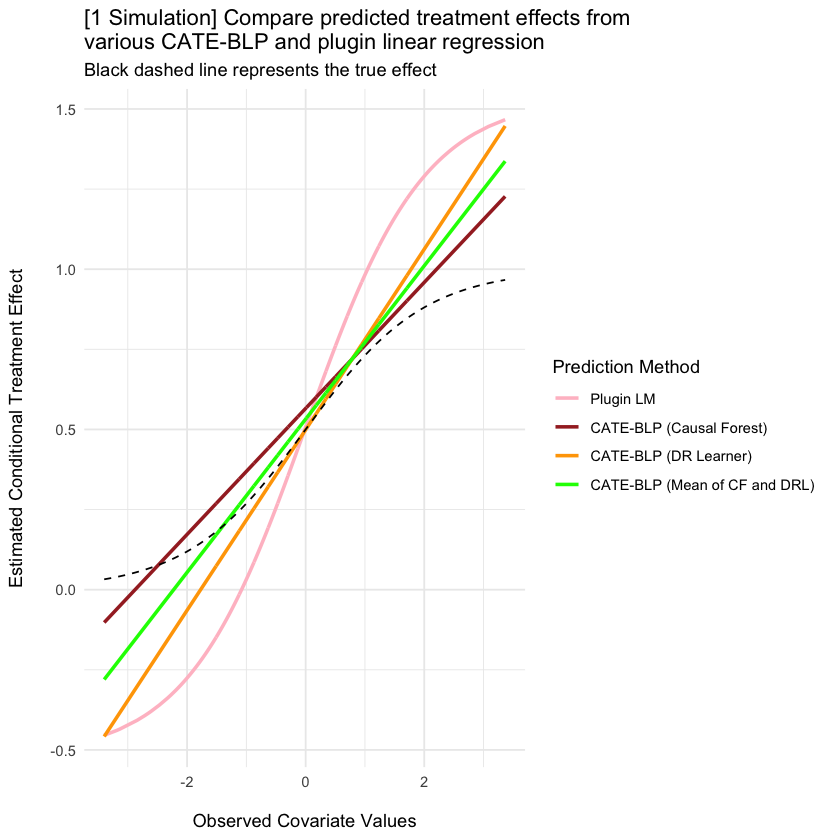

In [32]:
# Visually compare predictions
ggplot(comb_df, aes(x = A, y = prediction, color = type)) +
  geom_line(linewidth = 1) +
  geom_function(fun = tau_ex, col = "black", linetype = "dashed") +
  scale_color_manual(values = c("pink", "brown", "orange", "green"), name = "Prediction Method") +
  xlab("\nObserved Covariate Values") + ylab("Estimated Conditional Treatment Effect\n") +
  ggtitle("[1 Simulation] Compare predicted treatment effects from\nvarious CATE-BLP and plugin linear regression ",
    subtitle = "Black dashed line represents the true effect")

## Compare using hundreds of simulations

In [8]:
nsim = 400
n = 2000

results_mse <- data.frame(matrix(nrow = nsim, ncol = 4))
colnames(results_mse) <- c("plugin", "drl", "cf", "mean_drl_cf")

for (i in 1:nsim) {
  # Simulate data
  p <- 20
  X <- matrix(rnorm(n * p), n, p)

  # CATE varies along one dim only.
  tau_ex <- function(x) {
    1 / (1 + exp(-x))
  }
  TAU <- tau_ex(X[, 3])

  # Propensity  and Outcome vary along 2 and 5 dimensions only.
  W <- rbinom(n, 1, 1 / (1 + exp(-X[, 1] - X[, 2])))
  Y <- pmax(X[, 2] + X[, 3], 0) + rowMeans(X[, 4:6]) / 2 + W * TAU + rnorm(n)

  # Predict from simple lm
  lm_fitted <- lm(Y ~ X[,c(1:2, 4:p)] + W * TAU)

  lm_pred <- data.frame(lm_predicted =
                            (lm_fitted$coefficients["W"] +
                                lm_fitted$coefficients["TAU"] * TAU +
                                (lm_fitted$coefficients["W:TAU"] * TAU)) -
                            lm_fitted$coefficients["TAU"] * TAU)

  # CATE-BLP
  cf <- causal_forest(X, Y, W)
  blp_cf <- cate_blp(cf, X[, 3])
  blp_cf_pred <- predict(blp_cf)

  drl <- dr_learner(X, Y, W)
  blp_drl <- cate_blp(drl, X[, 3])
  blp_drl_pred <- predict(blp_drl)

  results_mse$plugin[i] <- mean((lm_pred$lm_predicted - TAU)^2)
  results_mse$drl[i] <- mean((blp_drl_pred$predicted - TAU)^2)
  results_mse$cf[i] <- mean((blp_cf_pred$predicted - TAU)^2)
  results_mse$mean_drl_cf[i] <- mean( ((blp_drl_pred$predicted + blp_cf_pred$predicted)/2 - TAU)^2)
}

In [9]:
summary(results_mse)

     plugin              drl                  cf             mean_drl_cf       
 Min.   :0.004838   Min.   :0.0007164   Min.   :0.0006274   Min.   :0.0006372  
 1st Qu.:0.035468   1st Qu.:0.0030234   1st Qu.:0.0029960   1st Qu.:0.0026288  
 Median :0.049439   Median :0.0070514   Median :0.0060474   Median :0.0055352  
 Mean   :0.052278   Mean   :0.0111246   Mean   :0.0085194   Mean   :0.0083859  
 3rd Qu.:0.064466   3rd Qu.:0.0147150   3rd Qu.:0.0118602   3rd Qu.:0.0120466  
 Max.   :0.135469   Max.   :0.1367045   Max.   :0.0443504   Max.   :0.0405551  

In [10]:
df_mse <- pivot_longer(results_mse, cols = 1:4)
df_mse$name <- factor(df_mse$name, 
                        levels = c("plugin", "cf", "drl", "mean_drl_cf"),
                        labels = c("Plugin LM", "CATE-BLP (Causal Forest)", "CATE-BLP (DR Learner)",
                                    "CATE-BLP (Mean of CF and DRL)"))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


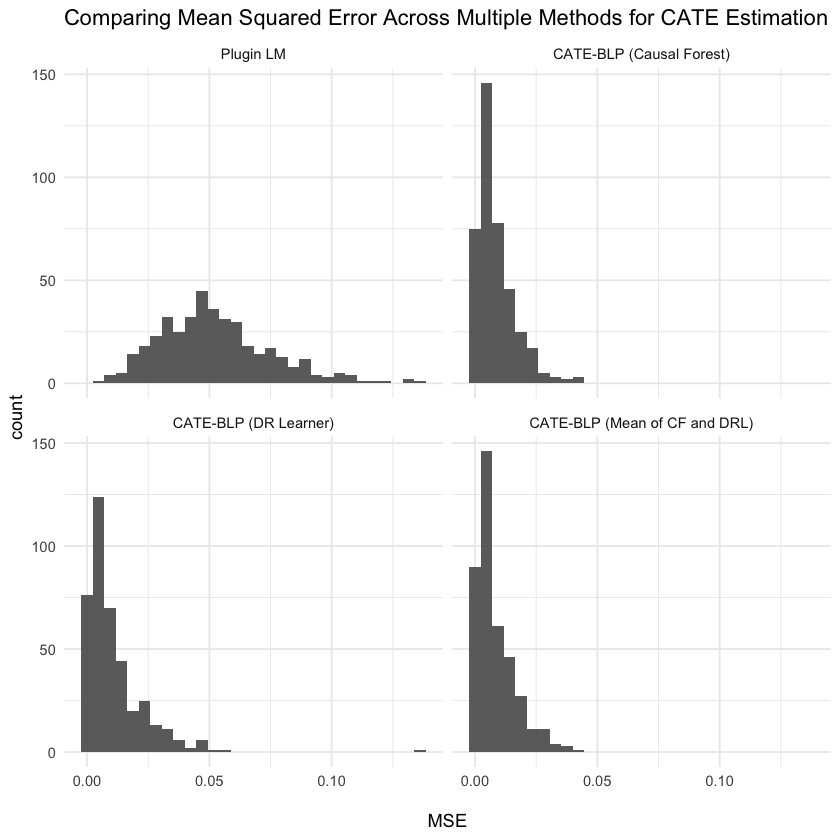

In [12]:
ggplot(df_mse, aes(value)) +
    facet_wrap(.~name) +
    geom_histogram(alpha = 0.9) +
    xlab("\nMSE") +
    ggtitle("Comparing Mean Squared Error Across Multiple Methods for CATE Estimation")

## Data generating process from Kennedy (2022)

In [77]:
nsim <- 20
expit <- function(x){ exp(x)/(1+exp(x)) }; logit <- function(x){ log(x/(1-x)) }
method_names <- c("cf", "drl", "mean_drl_cf")
results_mse_high <- data.frame(matrix(nrow=nsim,ncol=length(method_names)))
colnames(results_mse_high) <- method_names
n <- 4*2000
d <- 500
alpha <- d/10
beta <- alpha

In [78]:
for (i in 1:nsim) {
    ## simulate data
    s <- sort(rep(1:4,n/4)) 
    x <- matrix(rnorm(n*d), n, d)
    mu0 <- expit(as.numeric(x %*% rep(c(1, 0), c(beta,d-beta)))/sqrt(beta/1))
    ps <- expit(as.numeric(x %*% rep(c(1, 0), c(alpha,d-alpha)))/sqrt(alpha/0.25))
    TAU <- 0 
    mu1 <- mu0 + TAU
    w <- rbinom(n,1,ps) 
    y <- rbinom(n,1,a*mu1+(1-a)*mu0)

    # CATE-BLP
    cf <- causal_forest(x, y, w)
    blp_cf <- cate_blp(cf, x[, 3])
    blp_cf_pred <- predict(blp_cf)

    drl <- dr_learner(x, y, w, family = "binomial")
    blp_drl <- cate_blp(drl, x[, 3])
    blp_drl_pred <- predict(blp_drl)

    results_mse_high$drl[i] <- mean((blp_drl_pred$predicted - TAU)^2)
    results_mse_high$cf[i] <- mean((blp_cf_pred$predicted - TAU)^2)
    results_mse_high$mean_drl_cf[i] <- mean( ((blp_drl_pred$predicted + blp_cf_pred$predicted)/2 - TAU)^2)
}

Warning message:
“from glmnet C++ code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -72); Convergence for 72th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -84); Convergence for 84th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


In [79]:
summary(results_mse_high)

       cf                drl             mean_drl_cf      
 Min.   :0.005269   Min.   :0.0001179   Min.   :0.001906  
 1st Qu.:0.007327   1st Qu.:0.0005192   1st Qu.:0.003014  
 Median :0.008498   Median :0.0009759   Median :0.003600  
 Mean   :0.008760   Mean   :0.0010258   Mean   :0.003842  
 3rd Qu.:0.010013   3rd Qu.:0.0013262   3rd Qu.:0.004812  
 Max.   :0.013490   Max.   :0.0024503   Max.   :0.006436  

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


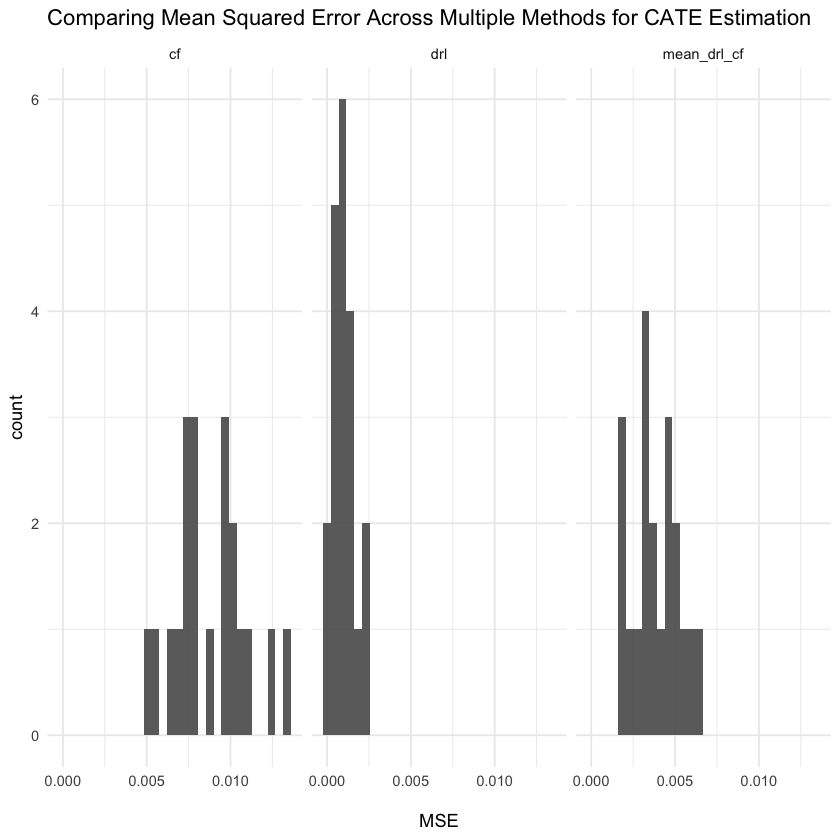

In [81]:
df_mse_high <- pivot_longer(results_mse_high, cols = 1:3)
ggplot(df_mse_high, aes(value)) +
    facet_wrap(.~name) +
    geom_histogram(alpha = 0.9) +
    xlab("\nMSE") +
    ggtitle("Comparing Mean Squared Error Across Multiple Methods for CATE Estimation")